# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, wilcoxon
import scanpy as sc

import OncoMark as oma

# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2024-04-11 11:46:37|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

# ICB in Melanoma. Riaz et al, Cell (2017).

In [3]:
RNAseq = pd.read_csv("../OncoMark/data/datasets/ICB/Melanoma-GSE91061/Melanoma-GSE91061.Response.RNAseq.tsv",  sep='\t', index_col=1).T
RNAseq = RNAseq.drop(index=["GENE_SYMBOL"])

RNAseq.sum(axis=1)
RNAseq = np.log2(RNAseq + 1)
RNAseq = RNAseq[["IGSF8"]]

metadata = pd.read_csv("../OncoMark/data/datasets/ICB/Melanoma-GSE91061/Melanoma-GSE91061.Response.metadata.tsv", sep='\t', index_col=1)
metadata2 = pd.read_excel("../OncoMark/data/datasets/ICB/Melanoma-GSE91061/patient_metadata.xlsx", skiprows=[0, 1], index_col=0)
metadata['subtypes'] = metadata['patient_name'].map(metadata2['Subtype'])

RNAseq_meta = RNAseq.join(metadata[["response", "patient_name", "subtypes", "Treatment"]], how='right') #
RNAseq_meta['response'] = RNAseq_meta['response'].map({"PD": "Non-benefit", "SD": "Benefit", "CR": "Benefit","PR": "Benefit"})
RNAseq_meta['response'] = pd.Categorical(RNAseq_meta['response'], categories=["Benefit", "Non-benefit"], ordered=True)
RNAseq_meta = RNAseq_meta[RNAseq_meta["response"].notna()]

In [4]:
RNAseq_meta.head()

,IGSF8,response,patient_name,subtypes,Treatment
SRR5088813,6.678315,Non-benefit,Pt1,CUTANEOUS,PRE
SRR5088814,6.627547,Non-benefit,Pt1,CUTANEOUS,ON
SRR5088815,4.772798,Benefit,Pt2,OTHER,PRE
SRR5088816,5.052349,Benefit,Pt2,OTHER,ON
SRR5088819,3.820641,Non-benefit,Pt39,MUCOSAL,PRE


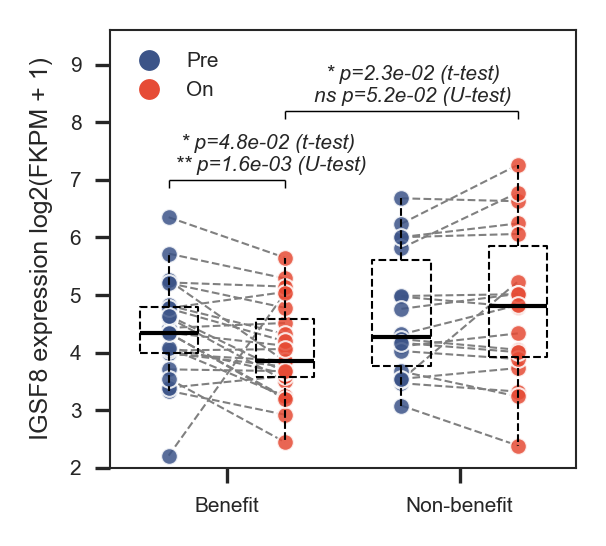

In [5]:
ben_Pre = RNAseq_meta.query('response=="Benefit" & Treatment=="PRE"').set_index("patient_name")
ben_On = RNAseq_meta.query('response=="Benefit" & Treatment=="ON"').set_index("patient_name")

Non_ben_Pre = RNAseq_meta.query('response=="Non-benefit" & Treatment=="PRE"').set_index("patient_name")
Non_ben_On = RNAseq_meta.query('response=="Non-benefit" & Treatment=="ON"').set_index("patient_name")

ben = ben_Pre.join(ben_On, rsuffix="_ON")[["IGSF8", "IGSF8_ON"]].dropna()
Non_ben = Non_ben_Pre.join(Non_ben_On, rsuffix="_ON")[["IGSF8", "IGSF8_ON"]].dropna()
ben['diff'] = ben['IGSF8_ON'] - ben['IGSF8'] 
Non_ben['diff'] = Non_ben['IGSF8_ON'] - Non_ben['IGSF8'] 

data_dict = {'Benefit - Pre': ben["IGSF8"].values,
             'Benefit - On': ben["IGSF8_ON"].values,
             'Non-benefit - Pre': Non_ben["IGSF8"].values,
             'Non-benefit - On': Non_ben["IGSF8_ON"].values,
            }

color_dict = {'Benefit - Pre': cmap.npg_palette(3),
              'Benefit - On':  cmap.npg_palette(0),
              'Non-benefit - Pre':  cmap.npg_palette(3),
              'Non-benefit - On':  cmap.npg_palette(0)
             }

tmp = ben[["IGSF8", "IGSF8_ON"]].dropna().values
_, benefit_pair_pval_rank = wilcoxon(tmp[:,0], tmp[:,1])
_, benefit_pair_pval_t = ttest_rel(tmp[:,0], tmp[:,1])

tmp = Non_ben[["IGSF8", "IGSF8_ON"]].dropna().values
_, Non_benefit_pair_pval_rank = wilcoxon(tmp[:,0], tmp[:,1])
_, Non_benefit_pair_pval_t = ttest_rel(tmp[:,0], tmp[:,1])

_, response_pre_pval_rank = mannwhitneyu(ben["IGSF8"], Non_ben["IGSF8"])
_, response_pre_pval_t = ttest_ind(ben["IGSF8"], Non_ben["IGSF8"])

_, response_on_pval_rank = mannwhitneyu(ben["IGSF8_ON"], Non_ben["IGSF8_ON"])
_, response_on_pval_t = ttest_ind(ben["IGSF8_ON"], Non_ben["IGSF8_ON"])

jitter = 0.
data_x_jitter = {}

i = 1
for k, v in data_dict.items():
    data_x_jitter.update({k: np.random.normal(loc=i, scale=jitter, size=len(v))})
    i += 1

fig, ax = plt.subplots(figsize=(2., 1.8))

for k,v in data_dict.items():
    ax.plot(data_x_jitter[k], data_dict[k], 'o', alpha=0.85, ms=4, mew=.5, mfc=color_dict[k], mec='white') 

boxprops = dict(color="black",linewidth=0.5, ls='--')
whiskerprops = dict(color="black",linewidth=0.5, ls='--')
medianprops = dict(color="black",linewidth=1.)    
plt.boxplot(data_dict.values(),
            showfliers = False,
            showcaps=False,
            widths =0.5,
            boxprops=boxprops,medianprops=medianprops, whiskerprops=whiskerprops
          )

for group in ["Benefit", "Non-benefit"]:
    for x1, x2, y1, y2 in zip(data_x_jitter[f'{group} - Pre'], data_x_jitter[f'{group} - On'], data_dict[f'{group} - Pre'], data_dict[f'{group} - On']):    
        ax.plot((x1, x2), (y1, y2), color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

# set xticklabels
xticks = list(data_dict.keys())
Xtick_tmp = pd.DataFrame([ax.get_xticks(),xticks]).T
Xtick_tmp.columns=['xticks', 'group']
Xtick_tmp["group"] = [grp.split(" - ")[0] for grp in Xtick_tmp["group"]]
Xtick_tmp = Xtick_tmp.groupby('group').mean().sort_values('xticks');
ax.set_xticks(Xtick_tmp['xticks'].astype(float).values, labels=Xtick_tmp.index);

plt.ylim(2, 9.6)

plt.hlines(y=7., xmin=1., xmax=2., color='k', lw=0.35)
plt.vlines(ymax=7., x=1., ymin=6.85, color='k', lw=0.35)
plt.vlines(ymax=7., ymin=6.85, x=2., color='k', lw=0.35)
plt.text(1., 7.15, f"{oma.pl.pval2star(benefit_pair_pval_t)} (t-test)\n{oma.pl.pval2star(benefit_pair_pval_rank)} (U-test)", fontsize=5, fontstyle="italic",)

plt.hlines(y=8.2, xmin=2, xmax=4, color='k', lw=0.35)
plt.vlines(ymax=8.2, ymin=8.05, x=2, color='k', lw=0.35)
plt.vlines(ymax=8.2, ymin=8.05, x=4, color='k', lw=0.35)
# plt.text(2.65, 8.35,  f"p={response_on_pval_t:.3f}", fontsize=5, fontstyle="italic",)
plt.text(2.25, 8.35,  f"{oma.pl.pval2star(response_on_pval_t)} (t-test)\n{oma.pl.pval2star(response_on_pval_rank)} (U-test)", fontsize=5, fontstyle="italic",)

from matplotlib.lines import Line2D
line1 = Line2D([], [], color="white", marker='o', markerfacecolor= cmap.npg_palette(3))
line2 = Line2D([], [], color="white", marker='o', markerfacecolor= cmap.npg_palette(0))
ax.legend((line1, line2), ('Pre', 'On'), numpoints=1, loc=(0.02, 0.82), ncols=1, fontsize=5, frameon=False)

plt.ylabel("IGSF8 expression log2(FKPM + 1)")
plt.savefig('../figures/Fig3G.pdf')

# ICB in Melanoma. Hugo et al, Cell (2016)

In [6]:
RNAseq = pd.read_csv("../OncoMark/data/datasets/ICB/PRJNA312948/rsem.tpm.reorder.log2tpm0.001.csv.gz", index_col=0).T
RNAseq = np.log2(np.exp2(RNAseq) - .001 + 1)
RNAseq = RNAseq[["IGSF8", "B2M", "PDCD1", "CD274"]]

metadata = pd.read_csv("../OncoMark/data/datasets/ICB/PRJNA312948/tumor_info.ext.txt", sep='\t')
metadata = metadata[metadata['biopsy time']=="pre-treatment"]

RNAseq_meta = RNAseq.join(metadata.set_index("SRR_id")["anti-pd-1 response"], how='right')

RNAseq_meta['anti-pd-1 response'] = RNAseq_meta['anti-pd-1 response'].map({"Progressive Disease": "PD",
                                                                           "Partial Response": "PR",
                                                                           "Complete Response": "CR",
                                                                          })
RNAseq_meta['anti-pd-1 response'] = pd.Categorical(RNAseq_meta['anti-pd-1 response'], categories=["CR", "PR", "PD"], ordered=True)

RNAseq_meta = RNAseq_meta.rename_axis("SRR").reset_index().set_index(["SRR", "anti-pd-1 response"]).stack().to_frame("Gene expression log2(TPM+1)")
RNAseq_meta = RNAseq_meta.rename_axis(["SRR", "anti-pd-1 response", "Genes"]).reset_index()

In [7]:
def complot(data, x, y, hue, title, ylabel, ax, cmap = oma.pl.cmap()):
    
    color = {"CR": cmap.npg_palette(2), "PR": cmap.npg_palette(3), "PD": cmap.npg_palette(0)}
    g = sns.stripplot(data=data,
                      x=x,
                      y=y,
                      hue=hue,
                      palette=color,
                      s=2.5,
                      legend=False,
                      ax=ax,
                      alpha=.75);

    g = sns.boxplot(data=data,
                    x=x,
                    y=y,
                    showfliers = False,
                    linewidth=.75,
                    color='dimgrey',
                    fill=False,
                    showcaps=False,
                    width=0.75,
                    ax=ax,
                    )

    g.set(ylim=(-.05, 23), xlabel="", ylabel=ylabel)
    ymin, ymax = g.get_ylim()
    xticklabels = [label.get_text() for label in g.get_xticklabels()]
    g.set_title(title, fontsize=6)

    i = 2
    for group1, group2 in combinations(xticklabels, 2):
        _, pval, _, _, _, _ = oma.tl.t_test(
            data=data,
            groupby=x,
            group1=group1,
            group2=group2,
            value=y,
        )
        
        _, pval_u, _, _, _, _ = oma.tl.u_test(
            data=data,
            groupby=x,
            group1=group1,
            group2=group2,
            value=y,
        )
        
        if pval <= 0.05 or pval_u <=0.05:
            pval = oma.pl.pval2star(pval)
            pval_u = oma.pl.pval2star(pval_u)
            g.text(
                (xticklabels.index(group1) + xticklabels.index(group2)) / 2 - .65,
                15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.08,
                f"{pval} (t-test)\n{pval_u} (U-test)",
                fontsize=4.6,
                fontstyle="italic",
            )
            g.hlines(
                15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.1,
                xmin=xticklabels.index(group1),
                xmax=xticklabels.index(group2),
                lw=0.35,
                color="k",
            )
            g.vlines(
                xticklabels.index(group1),
                ymin=15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.1-.5,
                ymax=15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.1,
                lw=0.35,
                color="k",
            )
            
            g.vlines(
                xticklabels.index(group2),
                ymin=15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.1-.5,
                ymax=15 + (ymax - ymin) * (i - 1) * 0.15 - (ymax - ymin) * 0.1,
                lw=0.35,
                color="k",
            )
            i += 1

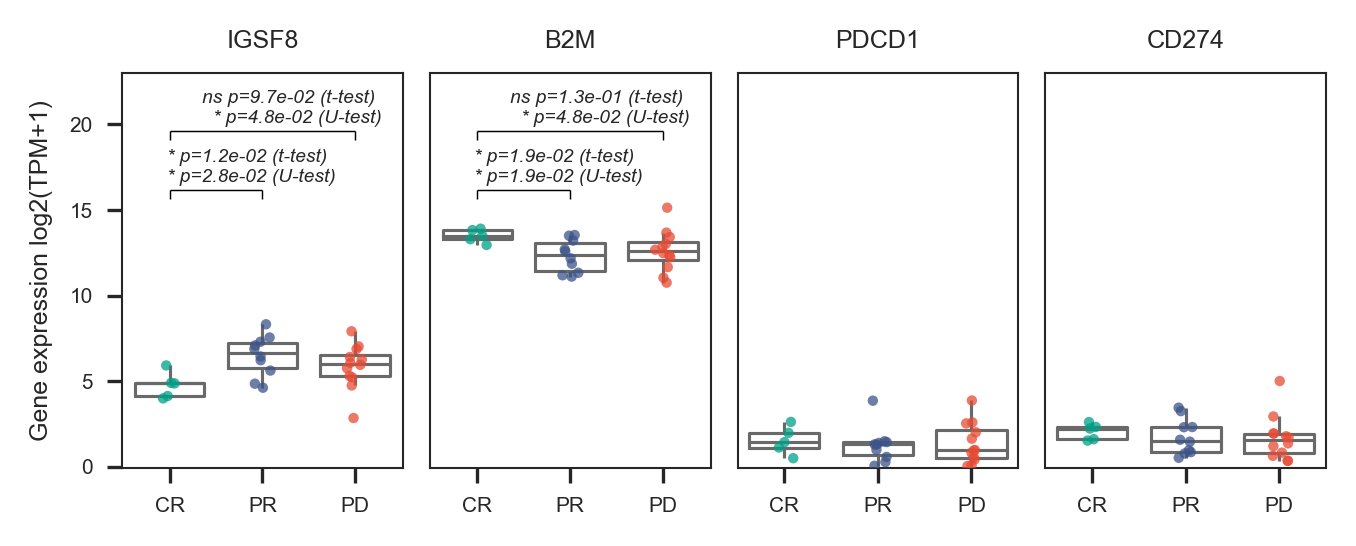

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4.5, 1.8))

for i, g in enumerate(["IGSF8", "B2M", "PDCD1", "CD274"]):
    
    if i == 0:     
        complot(data=RNAseq_meta.query('Genes==@g'),
                x="anti-pd-1 response",
                y="Gene expression log2(TPM+1)",
                hue="anti-pd-1 response",
                title=g,
                ax=axs[i],
                ylabel="Gene expression log2(TPM+1)",
               )
    else:
        complot(data=RNAseq_meta.query('Genes==@g'),
                x="anti-pd-1 response",
                y="Gene expression log2(TPM+1)",
                hue="anti-pd-1 response",
                title=g,
                ax=axs[i],
                ylabel="",
                
               )
        axs[i].tick_params(
            labeltop=False,
            labelleft=False,
            top=False,
            left=False,
            right=False,
        )
fig.savefig("../figures/FigS4C.pdf", bbox_inches='tight')